In [1]:
%reload_ext autoreload
%autoreload 2

import sys
import pickle
import json

import numpy as np
from scipy import stats
import jax.numpy as jnp

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import colormaps as cms
mpl.rc_file('../matplotlibrc')

In [2]:
sys.path.append("..")
from axionmirror.snr import load_snr_list, best_snrs, lightcurve_scale
import axionmirror.geometry as geom
import axionmirror.units_constants as uc
from axionmirror import graveyard
from estimates.config import wdir

In [4]:
# general
graveyard_dir = "/n/holyscratch01/iaifi_lab/yitians/all_sky_gegenschein/axion-mirror/outputs/snr"
fi_snr_list = load_snr_list("../outputs/snr/prebuild_snr_list_fullinfo.json")
gy_snr_list_0 = load_snr_list(f"{graveyard_dir}/graveyard_samples_base/graveyard_0.json")
snr_list = load_snr_list("../outputs/snr/prebuild_snr_list.json")

# age
t_now_arr = [snr.t_now for snr in snr_list if snr.t_now is not None]
log10age_fit_dict = json.load(open('../outputs/snr/log10age_fit_dict.json', 'r'))

# observed location
snr_lbd = np.array([[snr.l, snr.b, snr.d] for snr in snr_list if snr.d is not None])
snr_xyz = geom.GCxyz_stz(geom.GCstz(snr_lbd))


kernel, z_scale = pickle.load(open("../outputs/snr/snr_fi_kde_zscale.p", 'rb'))
npix = 300
z = 0
x_s, y_s = jnp.linspace(-12, 12, npix), jnp.linspace(-12, 12, npix)
x_grid, y_grid = jnp.meshgrid(x_s, y_s)
xyz = jnp.stack([x_grid, y_grid, jnp.full_like(x_grid, z*z_scale)], axis=0)
pdf_slice_kde = kernel.pdf(xyz.reshape(3, npix**2)).reshape(npix, npix)
xyz = jnp.stack([x_grid, y_grid, jnp.full_like(x_grid, z*z_scale)], axis=-1)

# graveyard location
# snr_lbd_gy = np.array([[snr.l, snr.b, snr.d] for snr in gy_snr_list_0])
# snr_xyz_gy = geom.GCxyz_stz(geom.GCstz(snr_lbd_gy))
pdf_slice_gy  = graveyard.snr_stz_pdf_G(geom.GCstz_xyz(xyz.reshape(npix**2, 3))).reshape(npix, npix)

# spectral index
si_arr = np.load("../outputs/snr/si_arr.npy")
si_fit_dict = json.load(open('../outputs/snr/si_fit_dict.json', 'r'))

# size
size_arr = np.load("../outputs/snr/snr_size_1000yr_arr.npy")
size_fit_dict = json.load(open('../outputs/snr/size_fit_dict.json', 'r'))

# L_pk t_pk
def L_pk(snr, t_pk):
   """Vectorized in t_pk."""
   # part of the build function
   p   = 2*snr.si+1 # si determines p
   ti1 = -2*(p+1)/5
   ti2 = -4*p/5
   ti  = ti2 # ti < 0
   Snu1GHz_t_free = snr.Snu1GHz * (snr.t_now/snr.t_free)**(-ti)
   Snu1GHz_pk = Snu1GHz_t_free / lightcurve_scale(t_pk, snr.t_free)
   Snu6p3GHz_pk = Snu1GHz_pk * (6.3/1)**(-snr.si)
   L_pk = 4*np.pi * (snr.d*uc.kpc)**2 * Snu6p3GHz_pk * uc.Jy * uc.sec**2
   return L_pk
def lL(snr, lt):
   return np.log10(L_pk(snr, 10**lt))

lt_arr = np.linspace(-3, 3, 300)
tm = np.log10(graveyard.t_pk_mean)
pt_arr = np.exp(-(lt_arr-tm)**2/(2*graveyard.t_pk_stddex**2))

lL_arr = np.linspace(24, 36, 300)
lm = np.log10(graveyard.L_pk_mean)
pL_arr = np.exp(-(lL_arr-lm)**2/(2*graveyard.t_pk_stddex**2))
lt_grid, lL_grid = np.meshgrid(lt_arr, lL_arr)
pLt = np.exp(-(lt_grid-tm)**2/(2 * graveyard.t_pk_stddex**2) - (lL_grid-lm)**2/(2*graveyard.t_pk_stddex**2))

fi_snr_list_s0 = load_snr_list("../outputs/snr/fullinfo_samples_base/fullinfo_0.json")
t_pk_arr = []
L_pk_arr = []
for snr in fi_snr_list_s0:
   t_pk_arr.append(snr.t_pk)
   L_pk_arr.append(snr.L_t(6300., snr.t_pk))

# L_t
i_sample = 0
ob_list = load_snr_list(f"../outputs/snr/fullinfo_samples_base/fullinfo_{i_sample}.json") \
        + load_snr_list(f"../outputs/snr/partialinfo_samples_base/partialinfo_{i_sample}.json")
ob_list_ti1 = load_snr_list(f"../outputs/snr/fullinfo_samples_ti1/fullinfo_{i_sample}.json") \
            + load_snr_list(f"../outputs/snr/partialinfo_samples_ti1/partialinfo_{i_sample}.json")
gy_list = load_snr_list(f"{graveyard_dir}/graveyard_samples_base/graveyard_{i_sample}.json")

# (removed)
#zs = np.load(f'{wdir}/CHIME-nnu10-nra1-ndec1/snr-graveyard-base/snr-graveyard-base-inu6-ira0-idec0.npy')

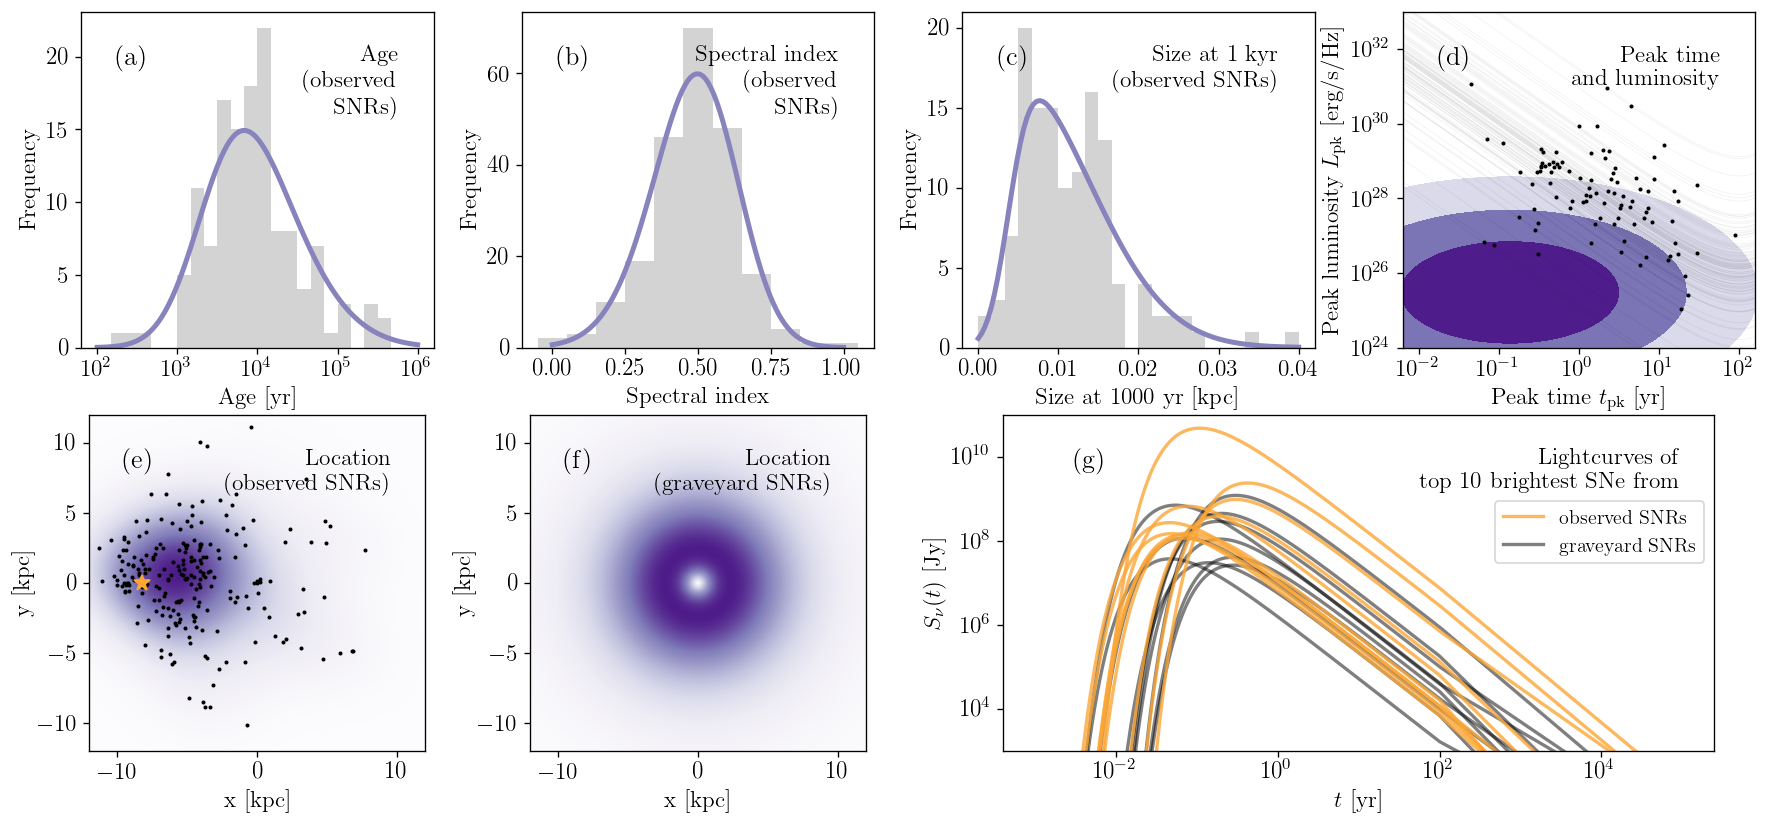

In [5]:
fig = plt.figure(figsize=(18, 8))
gs = mpl.gridspec.GridSpec(nrows=2, ncols=4, wspace=0.25)

show_str = 'abcdefg'
accent = cms['Purples'](0.6)
highlight = cms['plasma'](0.8)
fit_lw = 3

if 'a' in show_str: # Age
    ax = fig.add_subplot(gs[0, 0])
    bins = np.linspace(2, 6, 25)
    ax.hist(np.log10(t_now_arr), bins=bins, color='lightgray')
    plot_x = np.linspace(2, 6, 100)
    d = log10age_fit_dict
    plot_y = stats.skewnorm.pdf(plot_x, d['skewness'], loc=d['loc'], scale=d['scale'])
    ax.plot(plot_x, plot_y * len(np.log10(t_now_arr)) * np.diff(bins)[0], color=accent, lw=fit_lw)
    ax.set(xlabel='Age [yr]', ylabel='Frequency')
    ax.set_xticks(np.arange(2, 6+1))
    ax.set_xticklabels([f'$10^{i}$' for i in np.arange(2, 6+1)])
    ax.text(0.1, 0.9, '(a)', ha='left', va='top', transform=ax.transAxes, fontsize=16)
    ax.text(0.9, 0.9, 'Age\n(observed\nSNRs)', ha='right', va='top', transform=ax.transAxes, fontsize=14)

if 'b' in show_str: # spectral index
    ax = fig.add_subplot(gs[0, 1])
    si_bins = np.linspace(-0.05, 1.05, 12)
    si_counts, _, _ = ax.hist(si_arr, bins=si_bins, color='lightgray', label='Green\'s catalog')
    plot_x = np.linspace(0, 1, 100)
    d = si_fit_dict
    plot_y = stats.skewnorm.pdf(plot_x, d['skewness'], loc=d['loc'], scale=d['scale'])
    ax.plot(plot_x, plot_y * len(si_arr) * np.diff(si_bins)[0], color=accent, lw=fit_lw)
    ax.set(xlabel='Spectral index', ylabel='Frequency')
    ax.text(0.1, 0.9, '(b)', ha='left', va='top', transform=ax.transAxes, fontsize=16)
    ax.text(0.9, 0.9, 'Spectral index\n(observed\nSNRs)', ha='right', va='top', transform=ax.transAxes, fontsize=14)

if 'c' in show_str: # size
    ax = fig.add_subplot(gs[0, 2])
    bins = np.linspace(0, 0.04, 25)
    counts, _, _ = ax.hist(size_arr, bins=bins, color='lightgray', label='SNRcat+Green\'s')
    plot_x = np.linspace(0, 0.04, 100)
    d = size_fit_dict
    plot_y = stats.skewnorm.pdf(plot_x, d['skewness'], loc=d['loc'], scale=d['scale'])
    ax.plot(plot_x, plot_y * len(size_arr) * np.diff(bins)[0], color=accent, lw=fit_lw)
    ax.set(xlabel='Size at 1000 yr [kpc]', ylabel='Frequency')
    ax.text(0.1, 0.9, '(c)', ha='left', va='top', transform=ax.transAxes, fontsize=16)
    ax.text(0.9, 0.9, 'Size at 1 kyr\n(observed SNRs)', ha='right', va='top', transform=ax.transAxes, fontsize=14)

if 'd' in show_str: # Lpk tpk
    ax = fig.add_subplot(gs[0, 3])
    #ax.imshow(np.flipud(pLt), cmap='Purples', extent=(-3, 3, 24, 36), vmin=0, vmax=1.1*np.max(pLt), aspect='auto')
    ax.contourf(lt_arr, lL_arr, np.log(pLt), levels=np.log([1-0.9973, 1-0.95, 1-0.68, 1.]), cmap='Purples')
    ax.scatter(np.log10(t_pk_arr), np.log10(L_pk_arr), s=2, c='k', alpha=1)
    for snr in fi_snr_list_s0:
        ax.plot(lt_arr, lL(snr, lt_arr), lw=0.5, alpha=0.05, color='k')
    ax.set(xlim=(-2.2, 2.2), ylim=(24, 33))
    ax.set_xticks(np.arange(-2, 2+1))
    ax.set_xticklabels([r'$10^{%d}$' % i for i in np.arange(-2, 2+1)])
    ax.set_yticks(np.arange(24, 33, 2))
    ax.set_yticklabels([r'$10^{%d}$' % i for i in np.arange(24, 33, 2)])
    ax.set(xlabel=r'Peak time $t_\mathrm{pk}$ [yr]', ylabel=r'Peak luminosity $L_\mathrm{pk}$ [erg/s/Hz]')
    ax.text(0.1, 0.9, '(d)', ha='left', va='top', transform=ax.transAxes, fontsize=16)
    ax.text(0.9, 0.9, 'Peak time\nand luminosity', ha='right', va='top', transform=ax.transAxes, fontsize=14)

if 'e' in show_str: # Location observed
    ax = fig.add_subplot(gs[1, 0])
    ax.imshow(np.flipud(pdf_slice_kde), extent=(-12, 12, -12, 12), cmap=cms['Purples'], vmin=0, vmax=1.1*np.max(pdf_slice_kde))
    ax.scatter(snr_xyz[:, 0], snr_xyz[:, 1], s=2, c='k')
    #ax.scatter(snr_xyz_gy[:, 0], snr_xyz_gy[:, 1], s=2, c='gray', alpha=0.1)
    ax.plot([-uc.r_Sun], [0], c=highlight, marker='*', ms=10)
    ax.set(xlim=(-12, 12), ylim=(-12, 12), aspect=1)
    ax.set(xlabel='x [kpc]')
    ax.set_ylabel('y [kpc]', labelpad=1)
    ax.text(0.1, 0.9, '(e)', ha='left', va='top', transform=ax.transAxes, fontsize=16)
    ax.text(0.9, 0.9, 'Location\n(observed SNRs)', ha='right', va='top', transform=ax.transAxes, fontsize=14)

if 'f' in show_str: # Location graveyard
    ax = fig.add_subplot(gs[1, 1])
    ax.imshow(np.flipud(pdf_slice_gy), extent=(-12, 12, -12, 12), cmap=cms['Purples'], vmin=0, vmax=1.1*np.max(pdf_slice_gy))
    ax.set(xlim=(-12, 12), ylim=(-12, 12), aspect=1)
    ax.set(xlabel='x [kpc]')
    ax.set_ylabel('y [kpc]', labelpad=1)
    ax.text(0.1, 0.9, '(f)', ha='left', va='top', transform=ax.transAxes, fontsize=16)
    ax.text(0.9, 0.9, 'Location\n(graveyard SNRs)', ha='right', va='top', transform=ax.transAxes, fontsize=14)

if 'g' in show_str:
    ax = fig.add_subplot(gs[1, 2:4])
    nu_ref = 1000 # [MHz]
    t_plot = np.geomspace(0.001, 1e5, 1000)
    top_n = 10
    colors = {
        'base' : highlight,
        #'ti1' : cms['plasma'](0.4),
        'gy' : 'k',
    }

    plot_kwargs = dict(lw=2)
    for i, snr in enumerate(best_snrs(ob_list, top_n)):
        ax.plot(t_plot, snr.Snu_t(nu_ref, t_plot), color=colors['base'], zorder=2, alpha=0.8, label=(f'observed SNRs' if i==0 else None), **plot_kwargs)
    # for i, snr in enumerate(best_snrs(ob_list_ti1, top_n)):
    #     ax.plot(t_plot, snr.Snu_t(nu_ref, t_plot), color=colors['ti1'], zorder=1, **plot_kwargs)
    for i, snr in enumerate(best_snrs(gy_list, top_n)):
        ax.plot(t_plot, snr.Snu_t(nu_ref, t_plot), color=colors['gy'], zorder=0, alpha=0.5, label=(r'graveyard SNRs' if i==0 else None), **plot_kwargs)

    ax.set(xscale='log', yscale='log')
    ax.set(xlabel=r"$t$ [yr]", ylabel=r"$S_{\nu}(t)$ [Jy]", aspect=0.52)
    ax.set(ylim=(1e3, 1e11))
    ax.text(0.1, 0.9, '(g)', ha='left', va='top', transform=ax.transAxes, fontsize=16)
    text_kwargs = dict(ha='right', va='top', transform=ax.transAxes, fontsize=14)
    ax.text(0.95, 0.9, f'Lightcurves of\ntop {top_n} brightest SNe from', **text_kwargs)
    ax.legend(bbox_to_anchor=(1.0, 0.65), loc='center right', fontsize=12)
    #ax.text(0.95, 0.78, f'observed SNRs', color=colors['base'], **text_kwargs)
    #ax.text(0.9, 0.7, f'observed SNRs with alternative electron model', color=colors['ti1'], **text_kwargs)
    #ax.text(0.95, 0.7, f'graveyard SNRs', color=colors['gy'], **text_kwargs)

# if 'g' in show_str:
#     ax = fig.add_subplot(gs[1, 2:4])
#     im = ax.imshow(np.flipud(np.log10(np.clip(zs[0], 1e-9, None))), extent=(180, -180, -20, 90), vmin=-9, vmax=-4, cmap='magma')
#     ax.text(170, -0, f'Graveyard SNR realization', color='white', fontsize=12)
#     ax.text(170, -10, 'CHIME FOV', color='white', fontsize=12)
#     cbar = fig.colorbar(im, ax=ax, orientation='horizontal', aspect=40, label=r'$S_{\nu,\mathrm{st}}$ [Jy]', pad=0.02)
#     cbar.ax.set_xticks(np.arange(-9, -4+1))
#     cbar.ax.set_xticklabels([r'$10^{%d}$' % i for i in np.arange(-9, -4+1)]);

if show_str == 'abcdefg':
    plt.savefig('snr.pdf', bbox_inches='tight')

## Lightcurve

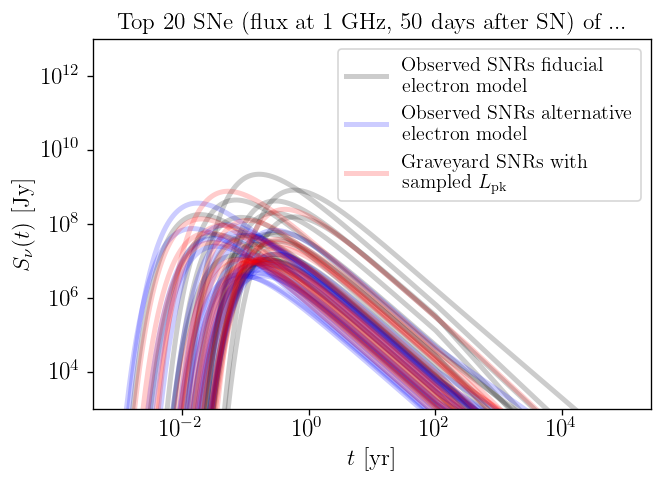

In [39]:
nu_ref = 1000 # [MHz]
t_plot = np.geomspace(0.001, 1e5, 1000)

i_sample = 1

fig, ax = plt.subplots()

ob_list = load_snr_list(f"../outputs/snr/fullinfo_samples/fullinfo_{i_sample}.json") \
        + load_snr_list(f"../outputs/snr/partialinfo_samples/partialinfo_{i_sample}.json")
for i, snr in enumerate(best_snrs(ob_list, 10)):
    label = 'Observed SNRs fiducial\nelectron model'
    ax.plot(t_plot, snr.Snu_t(nu_ref, t_plot), color='k', alpha=0.2, lw=3, label=(label if i==0 else None))

ob_list_ti1 = load_snr_list(f"../outputs/snr/fullinfo_samples_ti1/fullinfo_{i_sample}.json") \
            + load_snr_list(f"../outputs/snr/partialinfo_samples_ti1/partialinfo_{i_sample}.json")
for i, snr in enumerate(best_snrs(ob_list_ti1, 20)):
    label = 'Observed SNRs alternative\nelectron model'
    ax.plot(t_plot, snr.Snu_t(nu_ref, t_plot), color='b', alpha=0.2, lw=3, label=(label if i==0 else None))

gy_list = load_snr_list(f"../outputs/snr/graveyard_samples/graveyard_{i_sample}.json")
for i, snr in enumerate(best_snrs(gy_list, 20)):
    label = 'Graveyard SNRs with \nsampled ' + r'$L_\mathrm{pk}$'
    ax.plot(t_plot, snr.Snu_t(nu_ref, t_plot), color='r', alpha=0.2, lw=3, label=(label if i==0 else None))

ax.set(xscale='log', yscale='log')
ax.set(xlabel=r"$t$ [yr]", ylabel=r"$S_{\nu}(t)$ [Jy]", title='Top 20 SNe (flux at 1 GHz, 50 days after SN) of ...')

ax.set(ylim=(1e3, 1e13))
ax.legend();

In [17]:
from axionmirror.graveyard import sample_t_pk

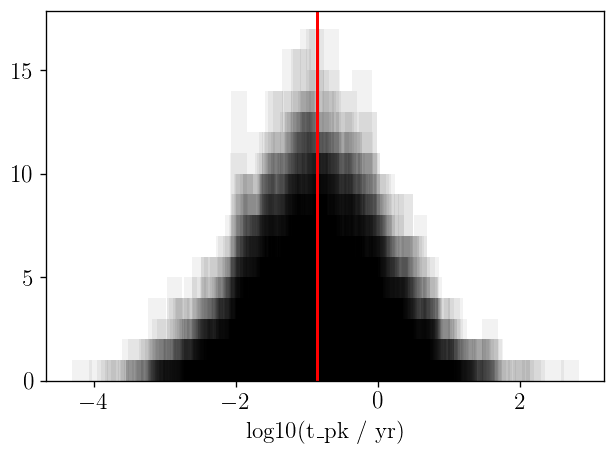

In [17]:
for i in range(100):
    valid_snr_list = load_snr_list(f"../outputs/snr/fullinfo_samples/fullinfo_{i}.json")
    t_pk_sample = [snr.t_pk for snr in valid_snr_list]
    plt.hist(np.log10(t_pk_sample), bins=20, alpha=0.05, color='k')
    plt.xlabel('log10(t_pk / yr)')
    plt.axvline(np.log10(50/365.25), color='r')